<center> <h1>PREDICIÓN DEL SUEÑO CON SVM</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>


###### Indice

En este jupyter notebook se lleva a cabo la construcción de un clasificador SVM tanto de salida binaria como multiclase para predecir tanto el estado de vigilia de los pacientes como el estado de sueño y sus distintas fases.

* **1. Cargar datos Train-Test**
  * **1.1 Preparación datos de entrada y salida**
* **2. Clasificador SVM Binario**
   * **2.1 Creación del modelo y selección parámetros libres**
   * **2.2 Búsqueda de parámetros con validación cruzada.**
   * **2.3 Evaluación del modelo**
* **3. Clasficador SVM Multiclase**
   * **3.1 Creación del modelo y selección parámetros libres**
   * **3.2 Búsqueda de parámetros con validación cruzada.**
   * **3.3 Evaluación del modelo**
   * **3.4 Visualización de residuos** 

IMPORTAR MÓDULOS

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statistics as stats
from sklearn.model_selection import GridSearchCV
from random import sample
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

## 1. CARGAR DATOS TRAIN-TEST

Se cargan los datos de train y test generados en los jupyter notebooks 'Nombre de los jupyter', en los que procesan los datos y se obtienen las características que se utilizan para entrenar los clasificadores. 

En el siguiente apartado se preparan los datos para seleccionar una salida binaria o multiclase según el clasificador que se vaya a utilizar.

### 2.1 Preparación datos de entrada y salida

In [2]:
#Train
Train= pd.read_csv('Train.csv')
#.drop(['Unnamed: 0'], axis = 1)
Test= pd.read_csv('Test.csv')
#.drop(['Unnamed: 0'], axis = 1)

In [3]:
X_train=Train.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1) 
y_train_bin=Train['Etiquetas binarias']
y_train_multi=Train['Etiquetas multiclase']

X_test=Test.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1)
y_test_bin=Test['Etiquetas binarias']
y_test_multi=Test['Etiquetas multiclase']

In [4]:
round(y_test_bin.describe(),2)

count    210.00
mean       0.63
std        0.48
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        1.00
Name: Etiquetas binarias, dtype: float64

In [5]:
#X_test

## 2. CLASIFICADOR SVM BINARIO

En este primer clasificador, se ha utilizado el método SVM para clasificar la vigilia o sueño ligero del sueño profundo. Es decir, se ha construido un clasificador SVM con salida binaria.

### 2.1  Creación del modelo y selección parámetros libres

En primer lugar, se construye un clasificador SVM de salida binaria sin búsqueda de parámetros. Se fija el valor de gamma o el valor de C y el otro se estima mediante la búsqueda del parámetro óptimo.

En el siguiente código se muestra como fijar un parámetro y barrer los posibles valores del otro.

In [6]:
clf = SVC(kernel='linear', gamma=1,decision_function_shape='ovr' ) # gamma=1 o C=10, depende del que queramos fijar
modelo_base=clf.fit(X_train,y_train_bin)

In [7]:
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 2.2  Búsqueda de parámetros con validación cruzada

A continuación, se realiza la búsqueda de parámetros. El parámetro gamma o C se fija y se hace un 'barrido' de los posibles valores del parámetro no fijado para elegir aquel que maximice la exactitud (accuracy).

Tras varias iteraciones se ha visto que los mejores parámetros son gamma=1 y C=10 para el clasificadro binario.


In [8]:
Cs =[0.1,1,10,100,1000]
# gamma = range(1,10,1) #si se quisiese estimar gamma
param_grid = { 'C': Cs  } #'gamma': gamma
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train, y_train_bin)
best_param=svc_grid.best_params_

In [9]:
# Clasificador con los mejores parámetros
svc_clf=svc_grid.best_estimator_

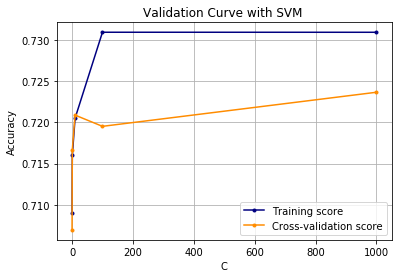

In [10]:
#parametro que queremos estimar
train_scores, test_scores = validation_curve(svc_clf, X_train, y_train_bin, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()


In [11]:
print("El valor más óptimo para el parámetro a estimar es:",best_param)

El valor más óptimo para el parámetro a estimar es: {'C': 1000}


In [12]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test,y_test_bin))
print("Tasa de acierto con la busqueda de parámetros:",svc_clf.score(X_test,y_test_bin))

#Mejora
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test,y_test_bin) - modelo_base.score(X_test,y_test_bin)) / modelo_base.score(X_test,y_test_bin)))

Tasa de acierto del modelo base: 0.6714285714285714
Tasa de acierto con la busqueda de parámetros: 0.680952380952381
Mejora  del 1.42%.


### 2.3 Evaluación del modelo

In [13]:
predict = svc_clf.predict(X_test)

#EVALUACION
acc_test= svc_clf.score(X_test, y_test_bin).round(4)
acc_train= svc_clf.score(X_train, y_train_bin).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print('Confusion Matrix')
print(confusion_matrix(y_test_bin, predict),'\n')

print("=============== Classification Report ================")
print(classification_report(y_test_bin, predict))
#matriz_confusion=pd.crosstab(Y_test,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.681 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.7319 

Confusion Matrix
[[ 13  64]
 [  3 130]] 

=============== Classification Report ================
              precision    recall  f1-score   support

         0.0       0.81      0.17      0.28        77
         1.0       0.67      0.98      0.80       133

    accuracy                           0.68       210
   macro avg       0.74      0.57      0.54       210
weighted avg       0.72      0.68      0.61       210



In [14]:
matriz_confusion=pd.crosstab(y_test_bin,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [15]:
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,13,64
1.0,3,130


### 2.4 Visualización de resultados

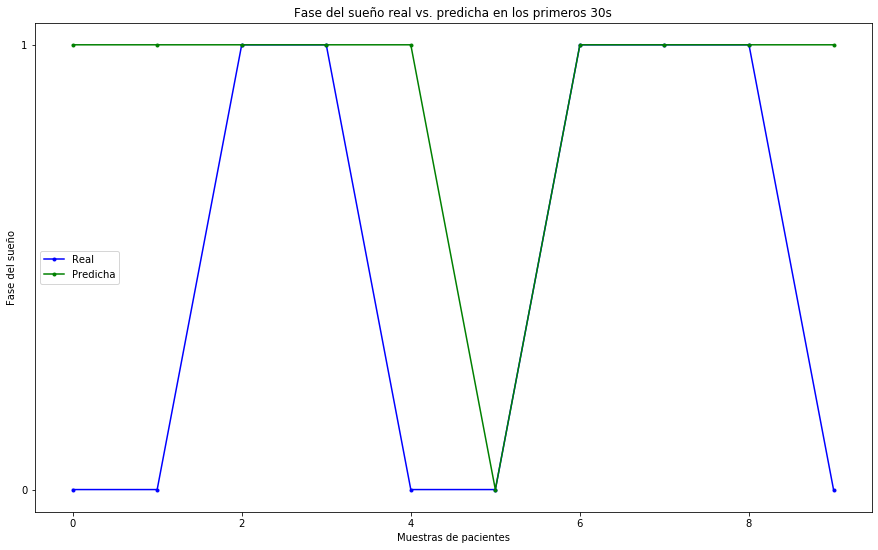

In [16]:
#EJEMPLO LOS 10 PRIMEROS
pacientes = len(y_test_bin[0:10])
t = np.arange(0,pacientes)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_bin[0:10],color='blue', marker='.',label='Real')
plt.plot(t,predict[0:10],color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.xlabel('Muestras de pacientes')
plt.ylabel('Fase del sueño')
plt.yticks([0,1])
#plt.xlim([0,10])
plt.legend()

## 3. CLASIFICADOR SVM MULTICLASE

Este segundo clasificador SVM tiene una salida multiclase y clasifica tanto el estado de vigilia como las distintas etapas de sueño ligero y profundo.

### 3.1 Creación del modelo y selección parámetros libres

En primer lugar, se construye un clasificador SVM de salida multiclase sin búsqueda de parámetros. Se fija el valor de gamma y se deja el valor de C por defecto.

In [17]:
clf = SVC(kernel='linear',gamma=0.1)
modelo_base=clf.fit(X_train,y_train_multi)

### 3.2 Búsqueda de parámetros con validación cruzada

In [18]:
Cs =[0.1,1,10,100,1000]
param_grid = {'C': Cs}
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train, y_train_multi)
C=svc_grid.best_params_

C:\Users\rober\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
# Clasificador con los mejores parámetros
svc_clf=svc_grid.best_estimator_

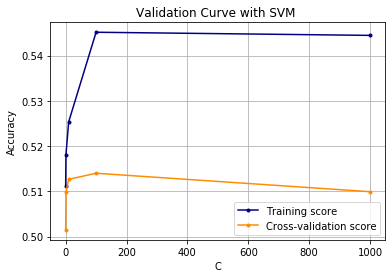

In [20]:
#parametro C

train_scores, test_scores = validation_curve(svc_clf, X_train, y_train_multi, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [21]:
print("C que maximiza la accuracy:",C)

C que maximiza la accuracy: {'C': 100}


In [22]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test,y_test_multi))
print("Tasa de acierto con la busqueda de parámetros:",svc_clf.score(X_test,y_test_multi))

#Mejora
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test,y_test_multi) - modelo_base.score(X_test,y_test_multi)) / modelo_base.score(X_test,y_test_multi)))

Tasa de acierto del modelo base: 0.4095238095238095
Tasa de acierto con la busqueda de parámetros: 0.40476190476190477
Mejora  del -1.16%.


### 3.3 Evaluación del modelo

In [23]:
predict = svc_clf.predict(X_test)

#EVALUACION
acc_test= svc_clf.score(X_test, y_test_multi).round(4)
acc_train= svc_clf.score(X_train, y_train_multi).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print('Confusion Matrix')
print(confusion_matrix(y_test_multi, predict),'\n')

print("=============== Classification Report ================")
print(classification_report(y_test_multi, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.4048 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.5403 

Confusion Matrix
[[ 4  0 27  0 11]
 [ 1  0 15  0  2]
 [ 0  0 73  0  5]
 [ 1  0 36  0  0]
 [ 2  0 25  0  8]] 

=============== Classification Report ================
              precision    recall  f1-score   support

         0.0       0.50      0.10      0.16        42
         1.0       0.00      0.00      0.00        18
         2.0       0.41      0.94      0.57        78
         3.0       0.00      0.00      0.00        37
         5.0       0.31      0.23      0.26        35

    accuracy                           0.40       210
   macro avg       0.24      0.25      0.20       210
weighted avg       0.31      0.40      0.29       210



C:\Users\rober\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
matriz_confusion=pd.crosstab(y_test_multi,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [25]:
matriz_confusion

Resultado del clasificador,0.0,2.0,5.0
Clase predicha,,,
0.0,4,27,11
1.0,1,15,2
2.0,0,73,5
3.0,1,36,0
5.0,2,25,8


### 3.4 Visualización predicción del sueño

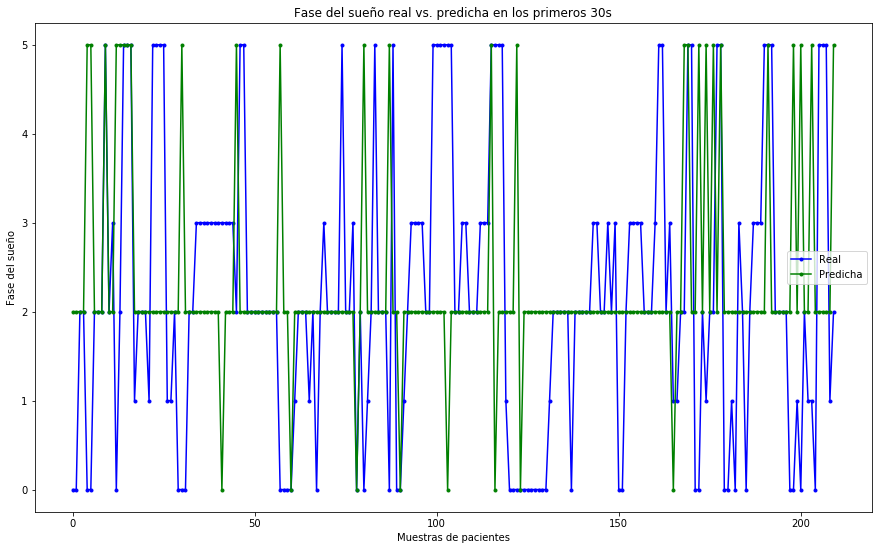

In [26]:
pacientes = len(y_test_multi)
t = np.arange(0,pacientes)
plt.figure(figsize=(15,9))
plt.plot(t,y_test_multi,color='blue', marker='.',label='Real')
plt.plot(t,predict,color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.xlabel('Muestras de pacientes')
plt.ylabel('Fase del sueño')
plt.legend()

* Estimamos parámetro por parámetro porque hacer los dos a la vez tarda mucho
* No se por qué pero al poner kernel='rbf' se hace todo rapidisimo pero solo reconoce una clase (no lo hace nada bien pero va rapido).
* No se detectan todas las clases en el multiclase --> necesitamos entrenar con mas datos y luego probar a estimar un parámetro y el otro como en el binario
* Baja accuracy en multiclase